# Deep Reindorecement Learning for stock trading Bot


Intsall packages (OpengymRL) 

In [3]:
!pip install stable-baselines3 gym-anytrading gym
!pip install tensorflow
!pip install alpaca-trade-api
!pip install stable-baselines3 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 KB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.4 MB/s eta 0:00:00
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.4
    Uninstalling msgpack-1.0.4:
      Successfully uninstalled msgpack-1.0.4
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.0.1
    Uninstalling charset-normalizer-3.0.1:
      Successfully uninstalled charset-normalizer-3.0.1
  Attempting uninstall: ai

In [112]:
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca_trade_api.stream import Stream

# Gym stuff
import gym
import gym_anytrading
import datetime as datetime

# Stable baselines - rl stuff
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from stable_baselines3.common.policies import CnnLstmPolicy

ImportError: ignored

## Set up API 

In [82]:
API_KEY = 'PKHVXASFLL723TV1GKIU'
SECRET_KEY = 'Y20GwDqaO7cKuKiCK7KPLOGGG4XfmW3mWdWOGfrN'


rest_api = REST(API_KEY, SECRET_KEY, 'https://paper-api.alpaca.markets')


symbol = ["AAPL"]
start = '2021-01-01'
end = '2022-01-01'


# Convert the start and end dates to a datetime object
start = datetime.datetime.strptime(start, '%Y-%m-%d')
end = datetime.datetime.strptime(end, '%Y-%m-%d')

df = rest_api.get_bars(symbol, TimeFrame.Day ,'2021-01-01', '2022-01-01').df

df.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2021-01-04 05:00:00+00:00,133.52,133.6116,126.760,129.41,143302685,1310227,129.732580,AAPL
2021-01-05 05:00:00+00:00,128.89,131.7400,128.430,131.01,97666310,707581,130.717947,AAPL
2021-01-06 05:00:00+00:00,127.72,131.0499,126.382,126.66,155088164,1202577,128.350213,AAPL
2021-01-07 05:00:00+00:00,128.36,131.6300,127.860,130.92,109578109,718358,130.153869,AAPL
2021-01-08 05:00:00+00:00,132.43,132.6300,130.230,132.05,105158275,800070,131.565744,AAPL


In [83]:
## convert timestamp to date

df.index = pd.to_datetime(df.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
df.index.names = ['Date']
df

,open,high,low,close,volume,trade_count,vwap,symbol
Date,,,,,,,,
2021-01-04,133.520,133.6116,126.760,129.41,143302685,1310227,129.732580,AAPL
2021-01-05,128.890,131.7400,128.430,131.01,97666310,707581,130.717947,AAPL
2021-01-06,127.720,131.0499,126.382,126.66,155088164,1202577,128.350213,AAPL
2021-01-07,128.360,131.6300,127.860,130.92,109578109,718358,130.153869,AAPL
2021-01-08,132.430,132.6300,130.230,132.05,105158275,800070,131.565744,AAPL
...,...,...,...,...,...,...,...,...
2021-12-27,177.085,180.4200,177.070,180.33,74928619,629427,179.056781,AAPL
2021-12-28,180.160,181.3300,178.530,179.29,79103834,631315,179.707003,AAPL
2021-12-29,179.330,180.6300,178.140,179.38,62325923,491575,179.455692,AAPL


In [84]:
## inspect data types 

df.dtypes

open           float64
high           float64
low            float64
close          float64
volume           int64
trade_count      int64
vwap           float64
symbol          object
dtype: object

In [85]:
## drop symbol column 
data = df.drop(columns = ["symbol","trade_count","vwap"])

## convert to float

data = data.astype("float")

data.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [92]:
data.index = pd.to_datetime(data.index)

In [96]:
## rename columns 

data= data.rename(columns = {"open":"Open","high": "High","low":"Low","close":"Close","volume":"Volume"})

data

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,133.520,133.6116,126.760,129.41,143302685.0
2021-01-05,128.890,131.7400,128.430,131.01,97666310.0
2021-01-06,127.720,131.0499,126.382,126.66,155088164.0
2021-01-07,128.360,131.6300,127.860,130.92,109578109.0
2021-01-08,132.430,132.6300,130.230,132.05,105158275.0
...,...,...,...,...,...
2021-12-27,177.085,180.4200,177.070,180.33,74928619.0
2021-12-28,180.160,181.3300,178.530,179.29,79103834.0
2021-12-29,179.330,180.6300,178.140,179.38,62325923.0


## Process data and setup environment 

In [98]:
env = gym.make('stocks-v0', df=data, frame_bound=(5,100), window_size=5)

In [99]:
env.signal_features

array([[ 1.294100e+02,  0.000000e+00],
       [ 1.310100e+02,  1.600000e+00],
       [ 1.266600e+02, -4.350000e+00],
       [ 1.309200e+02,  4.260000e+00],
       [ 1.320500e+02,  1.130000e+00],
       [ 1.289800e+02, -3.070000e+00],
       [ 1.288000e+02, -1.800000e-01],
       [ 1.308900e+02,  2.090000e+00],
       [ 1.289100e+02, -1.980000e+00],
       [ 1.271400e+02, -1.770000e+00],
       [ 1.278300e+02,  6.900000e-01],
       [ 1.320300e+02,  4.200000e+00],
       [ 1.368700e+02,  4.840000e+00],
       [ 1.390700e+02,  2.200000e+00],
       [ 1.429200e+02,  3.850000e+00],
       [ 1.431600e+02,  2.400000e-01],
       [ 1.420600e+02, -1.100000e+00],
       [ 1.370900e+02, -4.970000e+00],
       [ 1.319600e+02, -5.130000e+00],
       [ 1.341000e+02,  2.140000e+00],
       [ 1.349900e+02,  8.900000e-01],
       [ 1.339400e+02, -1.050000e+00],
       [ 1.373900e+02,  3.450000e+00],
       [ 1.367600e+02, -6.300000e-01],
       [ 1.369100e+02,  1.500000e-01],
       [ 1.360100e+02, -9

In [100]:
env.action_space

Discrete(2)

## Build Environment

info {'total_reward': 1.8650000000000517, 'total_profit': 0.6461207259987874, 'position': 0}


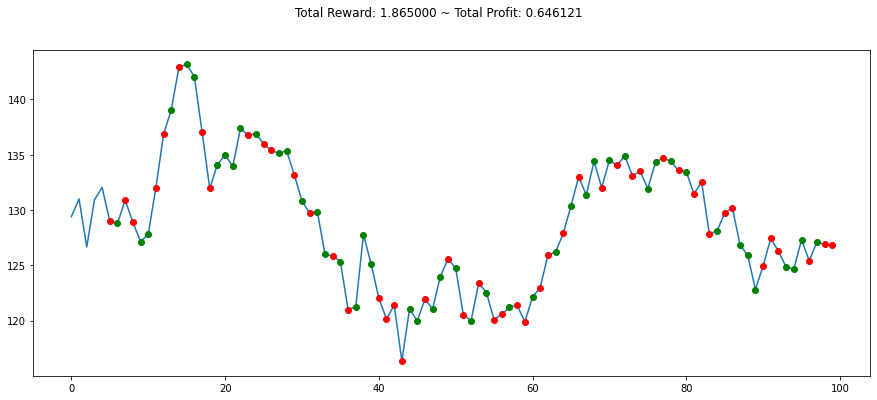

In [101]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

## Train the model and test 

In [102]:
env_maker = lambda: gym.make('stocks-v0', df=data, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])

In [115]:
model = A2C("MlpPolicy", env, verbose=1) 
model.learn(total_timesteps=1000000)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 7.95e-13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 736       |
|    iterations         | 62300     |
|    time_elapsed       | 423       |
|    total_timesteps    | 311500    |
| train/                |           |
|    entropy_loss       | -0.000168 |
|    explained_variance | -0.289    |
|    learning_rate      | 0.0007    |
|    n_updates          | 62299     |
|    policy_loss        | -2.38e-13 |
|    value_loss         | 6.41e-16  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 736       |
|    iterations         | 62400     |
|    time_elapsed       | 423       |
|    total_timesteps    | 312000    |
| train/                |           |
|    entropy_loss       | -0.000168 |
|    explained_variance | 0.115     |

KeyboardInterrupt: ignored

## Evaluate code


In [116]:
env = gym.make('stocks-v0', df=data, frame_bound=(90,110), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 0.9746932561788937, 'position': 1}


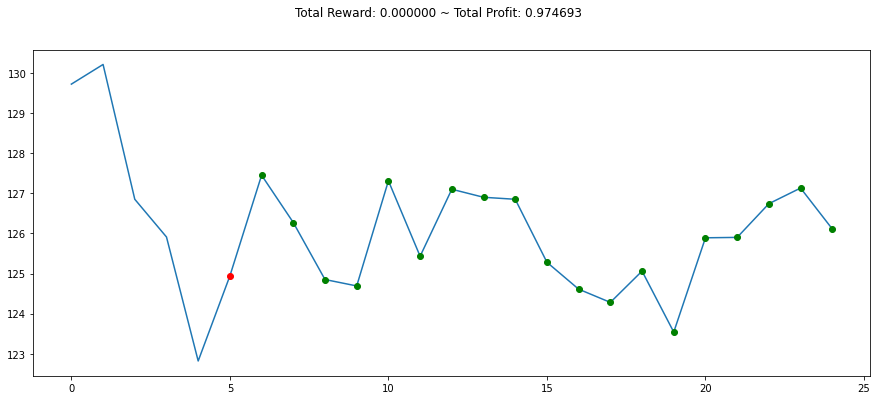

In [117]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()